<a href="https://colab.research.google.com/github/Yamunachowdary14/fmmllab-1/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-11 16:01:52--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 3.162.125.66, 3.162.125.83, 3.162.125.77, ...
Connecting to download.pytorch.org (download.pytorch.org)|3.162.125.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  71.0MB/s    in 0.6s    

2024-05-11 16:01:53 (71.0 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


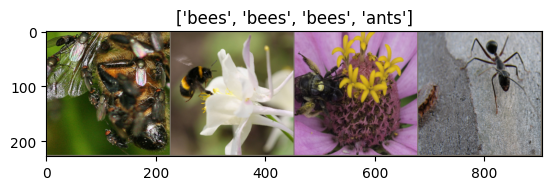

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 74.1MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.6401 Acc: 0.6803

Epoch 1/4
----------
Loss: 0.5364 Acc: 0.7705

Epoch 2/4
----------
Loss: 0.4705 Acc: 0.7992

Epoch 3/4
----------
Loss: 0.4648 Acc: 0.8115

Epoch 4/4
----------
Loss: 0.8463 Acc: 0.7377



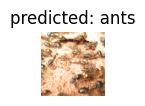

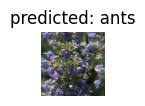

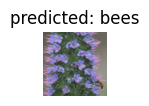

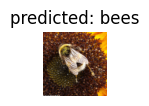

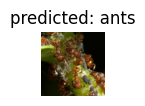

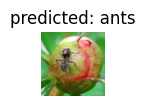

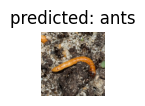

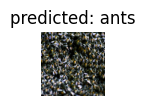

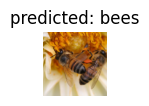

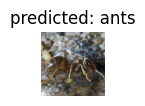

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


**ANSWER 1**

Data augmentations like resize, crop, flip, rotation, and others are techniques used to artificially increase the diversity of training data by applying various transformations to the existing dataset. There are several significant reasons for using data augmentations:

1. **Increased Robustness**: Augmentations help the model become more robust by exposing it to variations in the input data. For example, if you're training an image classification model and all your training images are perfectly centered and oriented, your model might not perform well on real-world data where objects can appear in different sizes, orientations, and positions. Augmentations like rotation, resizing, and cropping introduce such variations, making the model more adaptable to different scenarios.

2. **Regularization**: Data augmentation acts as a form of regularization, helping to prevent overfitting. By generating new training examples through augmentations, you effectively increase the size of your training dataset without actually collecting new data. This can help in reducing the model's tendency to memorize the training data and generalize better to unseen examples.

3. **Improved Generalization**: Augmentations encourage the model to learn more generalizable features rather than memorizing specific details of the training data. For instance, if your model needs to recognize cats in images, augmentations ensure that it learns to identify cats regardless of their position, orientation, or scale in the image.

4. **Reduced Bias**: Data augmentations can help reduce biases that might exist in the original dataset. For example, if your dataset contains only images of cats facing left, the model might learn to associate certain features specifically with left-facing cats. By applying horizontal flipping augmentation, you balance the representation of left and right-facing cats, thus reducing bias.

5. **Better Training Efficiency**: Augmentations can also improve training efficiency by effectively utilizing available data. Instead of collecting more data, which can be time-consuming and expensive, augmentations allow you to make the most out of the existing dataset.

Overall, data augmentations play a crucial role in improving the performance, robustness, and generalization capabilities of machine learning models, particularly in scenarios where the available training data is limited or biased.

**ANSWER 2**

If you don't use a pre-trained ResNet model and train it from scratch, the performance of the model might be significantly affected. Pre-trained models like ResNet have been trained on large-scale datasets (e.g., ImageNet) and have learned to extract useful features from images, which can be beneficial for various computer vision tasks, even if your target dataset is different from the dataset used for pre-training.

When you train a ResNet model from scratch without using pre-trained weights, the model starts with randomly initialized weights and learns from scratch using your dataset. Here are some potential outcomes:

1. **Performance Degradation**: Training a deep neural network from scratch without pre-trained weights may lead to performance degradation, especially if your dataset is relatively small or doesn't contain enough diverse examples to learn robust features.

2. **Increased Training Time**: Training a deep neural network from scratch typically requires more computational resources and time compared to fine-tuning a pre-trained model. The network has to learn both low-level and high-level features from scratch, which can be time-consuming.

3. **Higher Risk of Overfitting**: Without the regularization effect provided by pre-trained weights, there's a higher risk of overfitting to the training data, especially if the model architecture is complex and the dataset is small.

4. **Suboptimal Feature Learning**: Pre-trained models like ResNet have already learned to extract useful hierarchical features from images during pre-training. Without using pre-trained weights, the model may not learn these features optimally, leading to suboptimal performance on your target task.

To evaluate the performance of a ResNet model trained from scratch, you would typically compare its performance metrics (such as accuracy, precision, recall, etc.) on a validation set or test set with those obtained by using a pre-trained ResNet model. This comparison will help you understand the impact of using pre-trained weights on your specific task and dataset.

**ANSWER 3**
The performance of a pre-trained ResNet model on a dataset like ants vs. bees, which is significantly different from the dataset it was pre-trained on, can vary depending on several factors:

1. **Domain Similarity**: If the source dataset used for pre-training (e.g., ImageNet) shares some similarities with the target dataset (ants vs. bees), such as similar object categories or visual features, then the pre-trained model might still provide useful representations that generalize well to the target dataset.

2. **Feature Transferability**: Deep neural networks trained on large-scale datasets like ImageNet tend to learn generic features that are transferable across different visual recognition tasks. These features include low-level features like edges and textures as well as high-level semantic features like object parts and shapes. If the target dataset contains similar visual patterns or objects, the pre-trained model may still be able to leverage these learned features effectively.

3. **Fine-tuning and Adaptation**: Even if the pre-trained model doesn't perfectly match the target dataset, you can fine-tune it by updating its parameters on the target dataset while leveraging the knowledge encoded in the pre-trained weights. Fine-tuning allows the model to adapt its learned representations to the specifics of the target task and dataset, potentially improving performance.

4. **Model Capacity and Task Complexity**: The capacity of the pre-trained model and the complexity of the target task can also influence performance. A deeper and more complex pre-trained model like ResNet might capture more abstract features that could be beneficial for the target task, even if the datasets are dissimilar. However, if the target task is highly specialized or requires domain-specific knowledge not present in the pre-trained model, the performance gains may be limited.

Overall, while using a pre-trained ResNet model on a dataset like ants vs. bees, which is significantly different from the dataset it was pre-trained on, may still provide a good starting point, it's essential to evaluate the model's performance on the target dataset and potentially fine-tune it to achieve optimal results.